# Default + Baseline

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# colab에서 실행하기 위해 google drive에 업로드 하고 gdown을 통해 다운로드 하였음
# https://drive.google.com/file/d/1jW3yF-cSvDG4Al0ZTxvKNcgGkXmPfeyr/view?usp=drive_link

!gdown --id 1jW3yF-cSvDG4Al0ZTxvKNcgGkXmPfeyr
!unzip -q /content/chest_xray.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jW3yF-cSvDG4Al0ZTxvKNcgGkXmPfeyr
From (redirected): https://drive.google.com/uc?id=1jW3yF-cSvDG4Al0ZTxvKNcgGkXmPfeyr&confirm=t&uuid=0e175287-d3f9-4be8-b2de-657ea46541e3
To: /content/chest_xray.zip
100% 2.46G/2.46G [00:55<00:00, 44.7MB/s]


In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
# ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
ROOT_PATH = "/content"
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/content


In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/chest_xray/train/NORMAL/NORMAL2-IM-1175-0001.jpeg
Pneumonia image path
/content/chest_xray/train/PNEUMONIA/person1457_virus_2498.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return int(parts[-2] == "PNEUMONIA")   # 폐렴이면 양성(True), 노말이면 음성(False). // _MS_ 최신버전 TF에서는 bool을 지원하지 않아 int로 강제 형변환

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

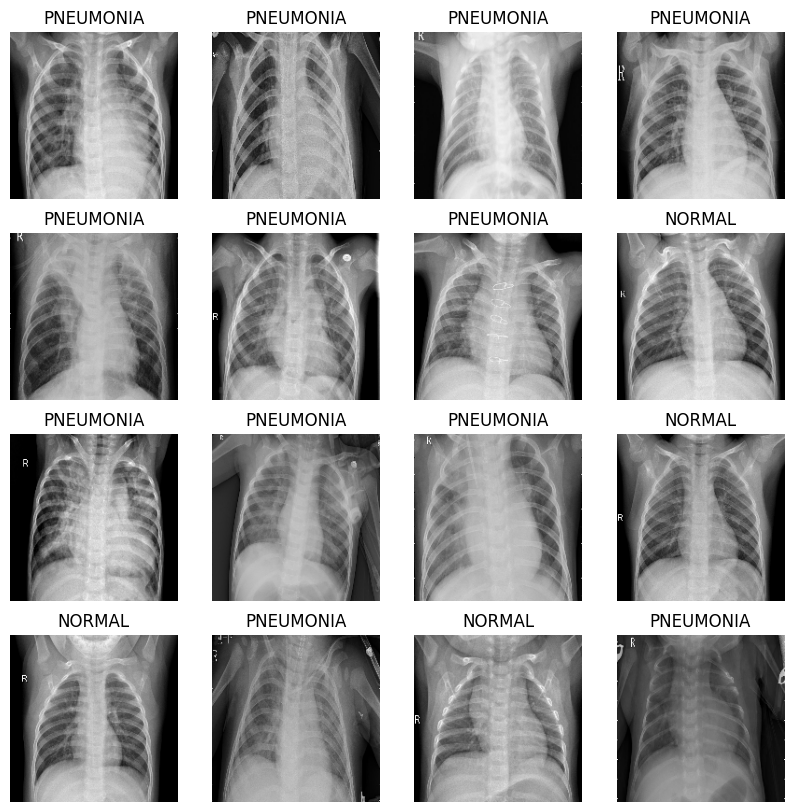

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
label_batch = tf.cast(label_batch, tf.int32)
show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 109s 284ms/step - accuracy: 0.7405 - loss: 0.5012 - precision: 0.9339 - recall: 0.6979 - val_accuracy: 0.7337 - val_loss: 0.6669 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 67s 259ms/step - accuracy: 0.9228 - loss: 0.2071 - precision: 0.9752 - recall: 0.9189 - val_accuracy: 0.7356 - val_loss: 1.0580 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 80s 306ms/step - accuracy: 0.9318 - loss: 0.1892 - precision: 0.9827 - recall: 0.9256 - val_accuracy: 0.9712 - val_loss: 0.0929 - val_precision: 0.9829 - val_recall: 0.9777
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 81s 311ms/step - accuracy: 0.9300 - loss: 0.1744 - precision: 0.9796 - recall: 0.9251 - val_accuracy: 0.9731 - val_loss: 0.0858 - val_precision: 0.9959 - val_recall: 0.9672
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 84s 321ms/step - accuracy: 0.9432 - loss: 0.1563 - precision: 0.9784 - recall: 0.9454 - val_accuracy: 0.476

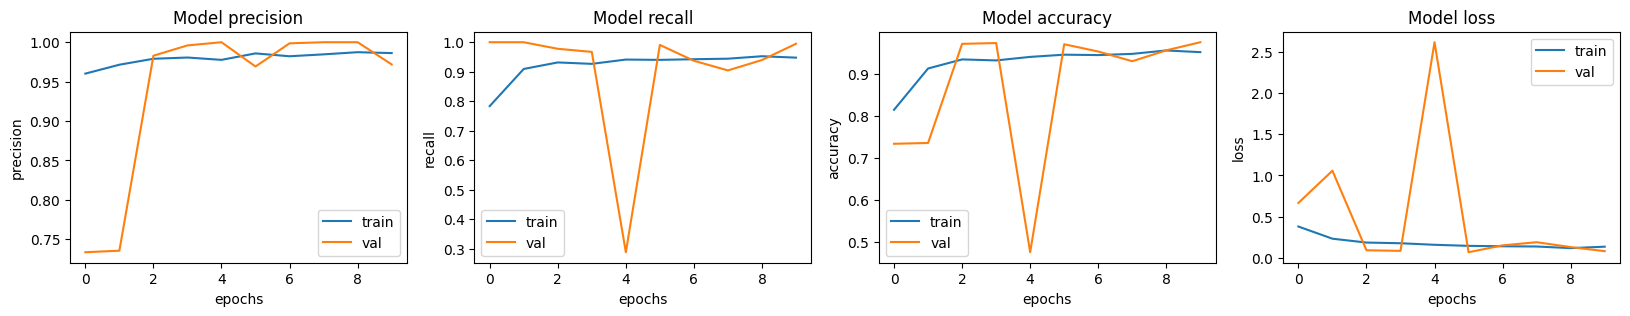

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.7309 - loss: 1.0517 - precision: 0.7098 - recall: 1.0000
Loss: 1.134743571281433,
Accuracy: 0.7035256624221802,
Precision: 0.678260862827301,
Recall: 1.0


# Augmentation + Baseline

In [59]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [60]:
# 이미지를 알맞은 형식으로 바꿉니다.
def augmentation_img(img):
    img = tf.image.random_flip_left_right(img)
    # img = tf.image.random_flip_up_down(img) # 이런 이미지는 없으니 굳이 넣을 필요가 없음
    # img = tf.image.random_brightness(img, 0.1) # 너무 분포가 달라지기 때문에 넣으면 안 됨
    return img

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

def process_path_for_train(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    img = augmentation_img(img) # 이미지를 Augmentation
    return img, label

In [61]:
train_ds = train_list_ds.map(process_path_for_train, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [62]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [63]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [64]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

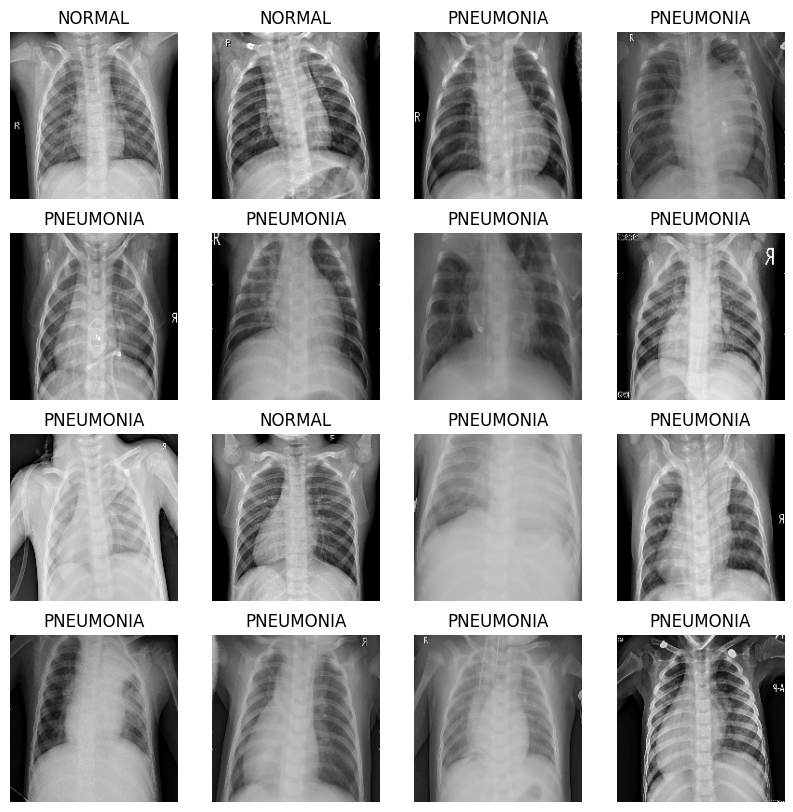

In [65]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
label_batch = tf.cast(label_batch, tf.int32)
show_batch(image_batch.numpy(), label_batch.numpy())

In [66]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 97s 268ms/step - accuracy: 0.7373 - loss: 0.5210 - precision: 0.9218 - recall: 0.7058 - val_accuracy: 0.7317 - val_loss: 0.6899 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 67s 259ms/step - accuracy: 0.8952 - loss: 0.2856 - precision: 0.9655 - recall: 0.8920 - val_accuracy: 0.7337 - val_loss: 0.9051 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 79s 305ms/step - accuracy: 0.9138 - loss: 0.2093 - precision: 0.9734 - recall: 0.9095 - val_accuracy: 0.7865 - val_loss: 0.4860 - val_precision: 0.7742 - val_recall: 1.0000
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 81s 313ms/step - accuracy: 0.9474 - loss: 0.1571 - precision: 0.9839 - recall: 0.9448 - val_accuracy: 0.9490 - val_loss: 0.1298 - val_precision: 0.9917 - val_recall: 0.9383
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 74s 284ms/step - accuracy: 0.9380 - loss: 0.1569 - precision: 0.9846 - recall: 0.9318 - val_accuracy: 0.9587

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.7827 - loss: 0.7075 - precision: 0.7490 - recall: 0.9944
Loss: 0.714037299156189,
Accuracy: 0.7676281929016113,
Precision: 0.7315689921379089,
Recall: 0.9923076629638672


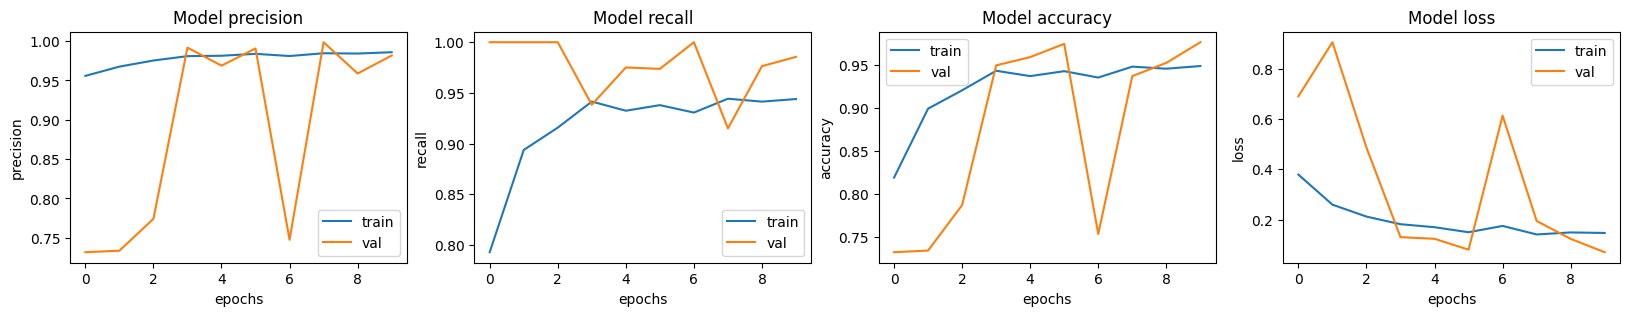

In [67]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

# Augmentation + Refined Baseline

In [70]:
def conv_add_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 5, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 5, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [72]:
def build_semi_refined_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_add_block(32),
        conv_add_block(64),

        conv_add_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_add_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

# model = build_semi_refined_model()
# model.summary()

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

# Augmentation + Resnet18

In [25]:
import tensorflow as tf

def conv_residual_block(x, filters, strides=1):
    shortcut = x

    x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

def create_resnet18():
    input_tensor = tf.keras.layers.Input(shape=(180, 180, 3))

    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.MaxPool2D(3, strides=2, padding='same')(x)
    x = conv_residual_block(x, 64)
    x = conv_residual_block(x, 64)

    x = conv_residual_block(x, 128, strides=2)
    x = conv_residual_block(x, 128)

    x = conv_residual_block(x, 256, strides=2)
    x = conv_residual_block(x, 256)

    x = conv_residual_block(x, 512, strides=2)
    x = conv_residual_block(x, 512)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output_tensor = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    return model

#model = create_resnet18()
#model.summary()


In [26]:
with tf.device('/GPU:0'):
    model = create_resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 105s 262ms/step - accuracy: 0.8383 - loss: 0.4629 - precision: 0.9345 - recall: 0.8402 - val_accuracy: 0.8740 - val_loss: 0.5066 - val_precision: 0.8557 - val_recall: 0.9961
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 82s 314ms/step - accuracy: 0.9246 - loss: 0.1940 - precision: 0.9736 - recall: 0.9247 - val_accuracy: 0.8933 - val_loss: 0.2349 - val_precision: 0.8744 - val_recall: 0.9974
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 80s 307ms/step - accuracy: 0.9328 - loss: 0.1677 - precision: 0.9807 - recall: 0.9286 - val_accuracy: 0.2654 - val_loss: 46.4886 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 73s 281ms/step - accuracy: 0.9433 - loss: 0.1485 - precision: 0.9815 - recall: 0.9428 - val_accuracy: 0.9212 - val_loss: 0.2513 - val_precision: 0.9038 - val_recall: 0.9987
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 75s 287ms/step - accuracy: 0.9520 - loss: 0.1097 - precision: 0.9865 - recall: 0.9486 - val_accura

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.8860 - loss: 0.5196 - precision: 0.8670 - recall: 0.9622
Loss: 0.5095496773719788,
Accuracy: 0.8894230723381042,
Precision: 0.8723897933959961,
Recall: 0.964102566242218


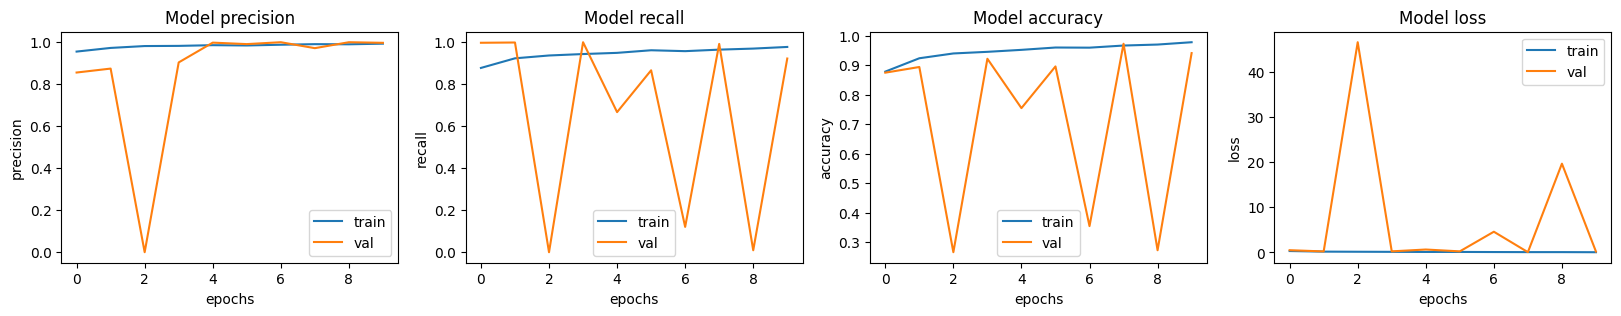

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')